# Homework Assignment  6

**Question 1:** Construct a sentiment classifier using 80% of the reviews in the [Amazon Fine Food Reviews dataset](https://www.kaggle.com/snap/amazon-fine-food-reviews).
The classifier needs to predict if a product got a one-star or a five-star review. 
Evaluate the classifier using the rest of the data (30pt). 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53430 sha256=6d169f9c171e62e1ee2bb2cfde008f45e1242b2d5100d0455ea2def26860a486
  Stored in directory: /root/.cache/pip/wheels/b0/05/90/43f79196199a138fb486902fceca30a2d1b5228e6d2db8eb90
Successfully built afinn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


 98% 237M/242M [00:02<00:00, 185MB/s]
100% 242M/242M [00:02<00:00, 122MB/s]
Archive:  amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              
Accuracy TF-IDF: 0.8874


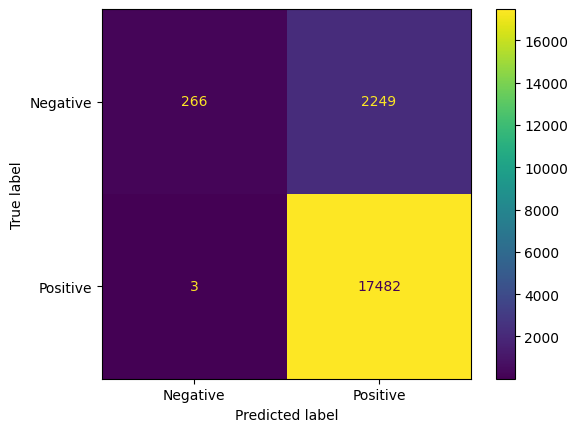

In [1]:
!pip install kaggle
!pip install nltk
!pip install afinn
!pip install -U textblob
!pip install transformers
!python -m spacy download en_core_web_lg 


import os
import json
import nltk
import torch
import numpy as np
import pandas as pd
import spacy
import en_core_web_lg
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from afinn import Afinn
from tqdm import tqdm
from transformers import RobertaTokenizer, RobertaModel

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('movie_reviews')

# Config kaggle
!mkdir /root/.kaggle/
api_token = {"username":"","key":""}
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
# Download data
!kaggle datasets download -d snap/amazon-fine-food-reviews
# Unzip data
!unzip -o amazon-fine-food-reviews.zip
# Read data
df = pd.read_csv("Reviews.csv")
# Define sentiment
def label2sentiment(label):
    if label == 5:
        return "Positive"
    elif label == 1:
        return "Negative"
    return np.nan
# Get sentiment
df['sentiment'] = df['Score'].apply(lambda label: label2sentiment(label))
df = df.dropna()
# Sample for saving time
df = df.sample(100000, random_state=42)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['sentiment'], test_size=0.2, random_state=42)
# Crete TF-IDF model
model = TfidfVectorizer(max_features = 2000, stop_words='english')
# Fit and transomr test and train to TF-IDF
X_train_tf_idf = model.fit_transform(X_train).toarray()
X_test_tf_idf = model.transform(X_test).toarray()
# Train sentiment classifier
clf = RandomForestClassifier(max_depth=20, random_state=42, n_jobs=-1)
clf.fit(X_train_tf_idf, y_train)
# Predict sentiment
y_predict = clf.predict(X_test_tf_idf)
# Print accuracy
print(f"Accuracy TF-IDF: {accuracy_score(y_test,y_predict)}")
# Display confusion matrix
cm = confusion_matrix(y_test, y_predict, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
ax = disp.plot()
plt.show()

**Question 2:** Construct a sentiment classifier using features from the [TextBlob package](https://textblob.readthedocs.io/en/dev/index.html),
    and from the [affin package](https://pypi.org/project/afinn/). Compare the two classifiers results and visualize it (however you want) (20pt)

Accuracy afinn: 0.9394


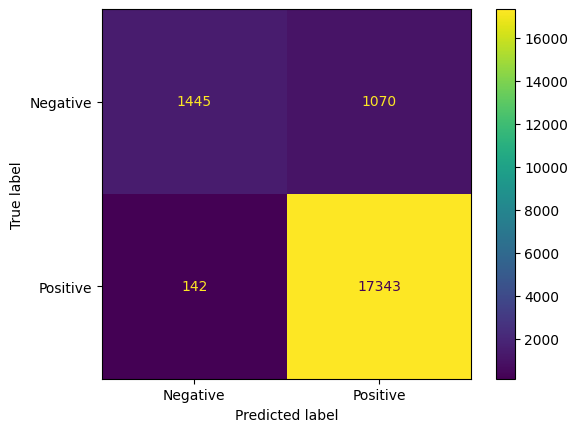

Accuracy TextBlob: 0.9391


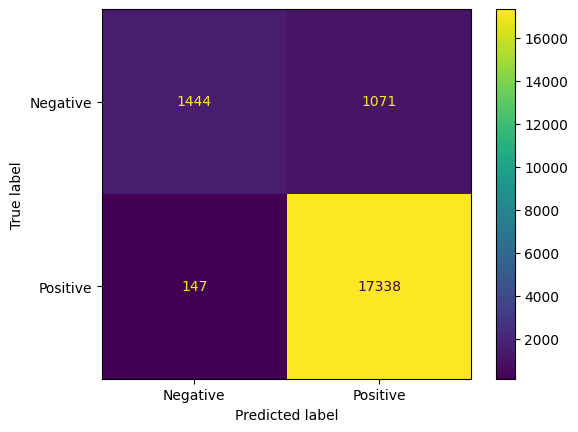

In [2]:
# Create model
afinn = Afinn()
# transform to dataframe
X_train = X_train.to_frame()
X_test = X_test.to_frame()
# Create dataframe of tf-idf
X_train_tf_idf = pd.DataFrame(X_train_tf_idf)
X_train_tf_idf.columns = X_train_tf_idf.columns.astype(str)
X_test_tf_idf = pd.DataFrame(X_test_tf_idf)
X_test_tf_idf.columns = X_test_tf_idf.columns.astype(str)
# Get afinn score
X_train_tf_idf['afinn_score'] = X_train["Text"].apply(lambda t: afinn.score(t)).to_numpy()
X_test_tf_idf['afinn_score'] = X_test["Text"].apply(lambda t: afinn.score(t)).to_numpy()
# Get TextBlob polarity
X_train_tf_idf['text_blob_polarity'] = X_train["Text"].apply(lambda t: TextBlob(t).sentiment.polarity).to_numpy()
X_test_tf_idf['text_blob_polarity'] = X_test["Text"].apply(lambda t: TextBlob(t).sentiment.polarity).to_numpy()
# Get TextBlob subjectivity
X_train_tf_idf['text_blob_subjectivity'] = X_train["Text"].apply(lambda t: TextBlob(t).sentiment.subjectivity).to_numpy()
X_test_tf_idf['text_blob_subjectivity'] = X_test["Text"].apply(lambda t: TextBlob(t).sentiment.subjectivity).to_numpy()
# Train sentiment classifier
clf = RandomForestClassifier()
clf.fit(X_train_tf_idf.drop(["text_blob_polarity", "text_blob_subjectivity"], axis=1), y_train)
# Predict sentiment
y_predict = clf.predict(X_test_tf_idf.drop(["text_blob_polarity", "text_blob_subjectivity"], axis=1))
# Print accuracy
print(f"Accuracy afinn: {accuracy_score(y_test,y_predict)}")
# Display confusion matrix
cm = confusion_matrix(y_test, y_predict, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
ax = disp.plot()
plt.show()
# Train sentiment classifier
clf = RandomForestClassifier()
clf.fit(X_train_tf_idf.drop(["afinn_score"], axis=1), y_train)
# Predict sentiment
y_predict = clf.predict(X_test_tf_idf.drop(["afinn_score"], axis=1))
# Print accuracy
print(f"Accuracy TextBlob: {accuracy_score(y_test,y_predict)}")
# Display confusion matrix
cm = confusion_matrix(y_test, y_predict, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
ax = disp.plot()
plt.show()

**Question 3:**  Select a different reviews dataset and create a sentiment classifier which utilizes word embeddings (25pt).
Evaluate this classifier (5pt). Try to improve your classifier by adding additional features (20pt)

 41% 5.00M/12.2M [00:00<00:00, 46.8MB/s]
100% 12.2M/12.2M [00:00<00:00, 64.2MB/s]
Archive:  100k-courseras-course-reviews-dataset.zip
  inflating: reviews.csv             
  inflating: reviews_by_course.csv   


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 2000/2000 [00:31<00:00, 62.81it/s]


Accuracy word embedding using spacy: 0.845


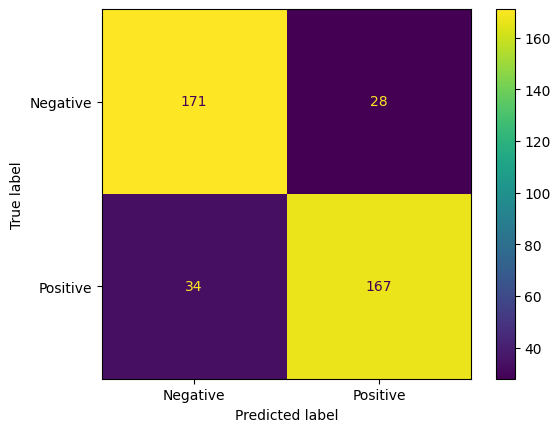

Accuracy word embedding using spacy + roberta: 0.9


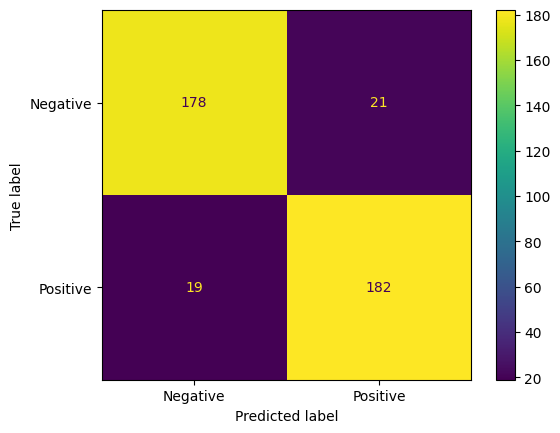

In [3]:
# Download data
!kaggle datasets download -d septa97/100k-courseras-course-reviews-dataset
# Unzip data
!unzip -o 100k-courseras-course-reviews-dataset.zip

# Create spcay object
nlp = en_core_web_lg.load()

# Read data
df = pd.read_csv("reviews.csv")
# Get sentiment
df['sentiment'] = df['Label'].apply(lambda label: label2sentiment(label))
df = df.dropna()
# Sample for saving time
neg_df = df[df.sentiment == "Negative"]
pos_df = df[df.sentiment == "Positive"]
df = pd.concat([neg_df.head(1000), pos_df.head(1000)])
# Load the pre-trained RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

def get_embeddings(text, tokinizer, model):
  # Tokenize the text and prepare it to be input to the model
  tokens = tokenizer.encode(text, add_special_tokens=True)
  tokens_tensor = torch.tensor(tokens).unsqueeze(0)

  # Get the RoBERTa model's output for the text
  outputs = model(tokens_tensor)

  # Extract the last hidden state of the RoBERTa model output
  last_hidden_state = outputs.last_hidden_state

  # Get the vector embeddings for the tokens in the text
  return last_hidden_state.squeeze(0).detach().numpy()
# Get roberta embeddings
vectors_list = []
texts = df["Review"].apply(lambda t: t[:514]).values
for text in tqdm(texts):
    vectors_list.append(get_embeddings(text, tokenizer, model))
vectors_list2 = [v[0] for v in vectors_list]
cols = [f"Feature {i}" for i in range(len(vectors_list2[0]))]
v_df = pd.DataFrame(data = vectors_list2,columns=cols)
# Get spacy embeddings
vectors_list_3 = []
for text in tqdm(texts):
    vectors_list_3.append(nlp(text).vector)
cols = [f"Spacy Feature {i}" for i in range(len(vectors_list_3[0]))]
v_df_2 = pd.DataFrame(data = vectors_list_3, columns=cols)
# Combine spacy & roberta embeddings
v_df_3 = pd.concat([v_df, v_df_2], axis=1)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(v_df_2, df['sentiment'], test_size=0.2, random_state=42)
# Train sentiment classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
# Predict sentiment
y_predict = clf.predict(X_test)
# Print accuracy
print(f"Accuracy word embedding using spacy: {accuracy_score(y_test,y_predict)}")
# Display confusion matrix
cm = confusion_matrix(y_test, y_predict, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
ax = disp.plot()
plt.show()
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(v_df_3, df['sentiment'], test_size=0.2, random_state=42)
# Train sentiment classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
# Predict sentiment
y_predict = clf.predict(X_test)
# Print accuracy
print(f"Accuracy word embedding using spacy + roberta: {accuracy_score(y_test,y_predict)}")
# Display confusion matrix
cm = confusion_matrix(y_test, y_predict, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
ax = disp.plot()
plt.show()